Obteniendo datos de PML para el nodo 01PLO-115 del 2025/07/10 al 2025/07/16...
Obteniendo datos para: 2025/07/10...
Obteniendo datos para: 2025/07/11...
Obteniendo datos para: 2025/07/12...
Obteniendo datos para: 2025/07/13...
Obteniendo datos para: 2025/07/14...
Obteniendo datos para: 2025/07/15...
Obteniendo datos para: 2025/07/16...

Datos obtenidos con éxito. Primeras 5 filas:
                    PML  PML_ENE  PML_PER  PML_CNG
Date       Time                                   
2025-07-10 1     602.25   560.70    41.55      0.0
           2     564.83   530.49    34.34      0.0
           3     538.89   506.11    32.79      0.0
           4     545.44   510.86    34.59      0.0
           5     548.92   515.75    33.17      0.0

Últimas 5 filas:
                    PML  PML_ENE  PML_PER  PML_CNG
Date       Time                                   
2025-07-16 20    674.98   619.27    55.71      0.0
           21    804.90   738.69    66.21      0.0
           22    676.44   619.82    5

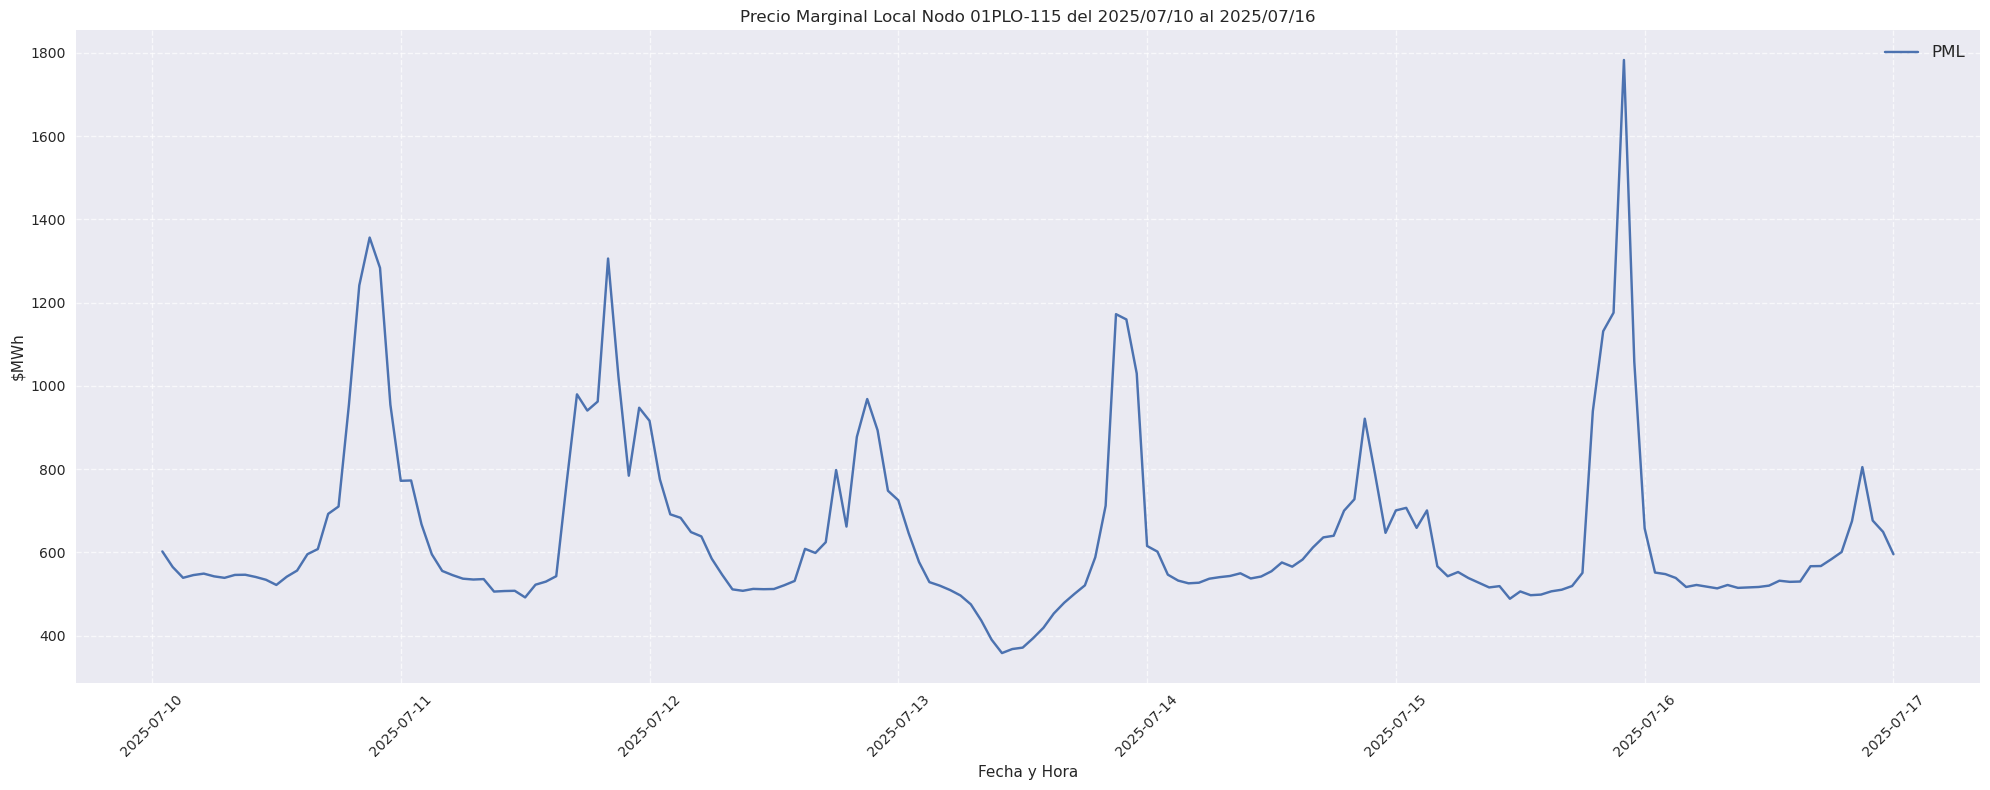


--- Análisis de PML para el Nodo 01PLO-115 ---
count     168.000000
mean      643.454821
std       211.901290
min       358.010000
25%       521.660000
50%       552.110000
75%       691.685000
max      1783.190000
Name: PML, dtype: float64

--- PML Promedio por Día ---
Date
2025-07-10    698.497391
2025-07-11    701.347083
2025-07-12    661.231250
2025-07-13    576.184583
2025-07-14    606.132500
2025-07-15    695.564167
2025-07-16    569.518750
2025-07-17    595.490000
Name: PML, dtype: float64

--- Hora con el PML más alto en el rango ---
(datetime.date(2025, 7, 15), np.int64(22))

--- Hora con el PML más bajo en el rango ---
(datetime.date(2025, 7, 13), np.int64(10))


In [1]:
import requests
import pandas as pd
from datetime import date, timedelta, datetime
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('seaborn-v0_8')

def obtener_datos_pml(id_nodo: str, fecha_objetivo: date) -> pd.DataFrame:
    """
    Obtiene datos de PML de la API de CENACE para un nodo y fecha específicos.

    Args:
        id_nodo (str): El ID del nodo (ej. '01PLO-115').
        fecha_objetivo (date): La fecha para la cual se desean obtener los datos.

    Returns:
        pd.DataFrame: Un DataFrame con los datos de PML, o un DataFrame vacío si ocurre un error.
    """
    fecha_str = fecha_objetivo.strftime("%Y/%m/%d")
    url = f'https://ws01.cenace.gob.mx:8082/SWPML/SIM/SIN/MDA/{id_nodo}/{fecha_str}/{fecha_str}/XML'

    try:
        respuesta = requests.get(url)
        respuesta.raise_for_status()  # Lanza un HTTPError para códigos de estado 4xx/5xx
    except requests.exceptions.HTTPError as e:
        print(f'Error HTTP al obtener datos de {url}: {e}')
        return pd.DataFrame()
    except requests.exceptions.ConnectionError as e:
        print(f'Error de conexión al obtener datos de {url}: {e}')
        return pd.DataFrame()
    except requests.exceptions.Timeout as e:
        print(f'Tiempo de espera agotado al obtener datos de {url}: {e}')
        return pd.DataFrame()
    except requests.exceptions.RequestException as e:
        print(f'Ocurrió un error inesperado al obtener datos de {url}: {e}')
        return pd.DataFrame()

    sopa = BeautifulSoup(respuesta.text, 'html.parser')

    horas_raw = [tag.getText() for tag in sopa.select('hora')] # Obtenemos las horas como texto primero
    pml_valores = [pd.to_numeric(tag.getText()) for tag in sopa.select('pml')]
    pml_ene_valores = [pd.to_numeric(tag.getText()) for tag in sopa.select('pml_ene')]
    pml_per_valores = [pd.to_numeric(tag.getText()) for tag in sopa.select('pml_per')]
    pml_cng_valores = [pd.to_numeric(tag.getText()) for tag in sopa.select('pml_cng')]

    # --- MODIFICACIÓN CLAVE AQUÍ ---
    # Procesar las horas para manejar el "24"
    fechas_modificadas = []
    horas_modificadas = []
    for hora_str in horas_raw:
        hora_int = int(hora_str)
        if hora_int == 24:
            # Si es la hora 24, se convierte a 00 y se asigna al día siguiente
            fechas_modificadas.append(fecha_objetivo + timedelta(days=1))
            horas_modificadas.append(0) # 0 representa 00:00
        else:
            fechas_modificadas.append(fecha_objetivo)
            horas_modificadas.append(hora_int)
    # --- FIN DE MODIFICACIÓN CLAVE ---

    datos = {
        'Date': fechas_modificadas, # Usamos las fechas ya ajustadas
        'Time': horas_modificadas,  # Usamos las horas ya ajustadas
        'PML': pml_valores,
        'PML_ENE': pml_ene_valores,
        'PML_PER': pml_per_valores,
        'PML_CNG': pml_cng_valores
    }

    df = pd.DataFrame(datos)
    # Ahora el índice ya tiene las fechas y horas correctas para la medianoche
    df.set_index(['Date', 'Time'], inplace=True)
    return df

def obtener_rango_pml(id_nodo: str, fecha_inicio: date, fecha_fin: date) -> pd.DataFrame:
    """
    Obtiene datos de PML para un rango de fechas especificado.

    Args:
        id_nodo (str): El ID del nodo.
        fecha_inicio (date): La fecha de inicio del rango (inclusive).
        fecha_fin (date): La fecha de fin del rango (inclusive).

    Returns:
        pd.DataFrame: Un DataFrame consolidado con los datos de PML para todo el rango.
    """
    if fecha_inicio > fecha_fin:
        print("La fecha de inicio no puede ser posterior a la fecha de fin.")
        return pd.DataFrame()

    lista_df = []
    fecha_actual = fecha_inicio
    while fecha_actual <= fecha_fin:
        print(f"Obteniendo datos para: {fecha_actual.strftime('%Y/%m/%d')}...")
        df_dia = obtener_datos_pml(id_nodo, fecha_actual)
        if not df_dia.empty:
            lista_df.append(df_dia)
        fecha_actual += timedelta(days=1)

    if lista_df:
        df_final = pd.concat(lista_df)
        return df_final
    else:
        print("No se pudieron obtener datos para el rango de fechas especificado.")
        return pd.DataFrame()

def graficar_rango_pml(df_rango: pd.DataFrame, id_nodo: str, fecha_inicio: date, fecha_fin: date):
    """
    Grafica el PML para un rango de fechas.

    Args:
        df_rango (pd.DataFrame): DataFrame con los datos de PML del rango.
        id_nodo (str): El ID del nodo.
        fecha_inicio (date): Fecha de inicio del rango.
        fecha_fin (date): Fecha de fin del rango.
    """
    if df_rango.empty:
        print("No hay datos para graficar.")
        return

    # Resetear el índice para que 'Date' y 'Time' sean columnas
    df_rango_reset = df_rango.reset_index()

    # Combinar 'Date' y 'Time' para crear una columna 'DateTime' que incluye la hora
    # pd.to_datetime ahora debería funcionar sin problemas porque las horas ya son 0-23
    df_rango_reset['DateTime'] = pd.to_datetime(
        df_rango_reset['Date'].astype(str) + ' ' + df_rango_reset['Time'].astype(str),
        format='%Y-%m-%d %H' # Especificar el formato, ya que Time es solo la hora
    )
    df_rango_reset.set_index('DateTime', inplace=True)

    fig, ax = plt.subplots(figsize=(20, 8))

    ax.plot(df_rango_reset.index, df_rango_reset['PML'], label='PML')
    
    ax.set_title(f'Precio Marginal Local Nodo {id_nodo} del {fecha_inicio.strftime("%Y/%m/%d")} al {fecha_fin.strftime("%Y/%m/%d")}')
    ax.set_ylabel('$MWh')
    ax.set_xlabel('Fecha y Hora')
    ax.legend(fontsize=12)
    plt.xticks(rotation=45) # Rotar las etiquetas del eje X para mejor legibilidad
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def analizar_rango_pml(df_rango: pd.DataFrame, id_nodo: str):
    """
    Realiza un análisis básico del PML para un rango de fechas.
    """
    if df_rango.empty:
        print("No hay datos para analizar.")
        return

    print(f"\n--- Análisis de PML para el Nodo {id_nodo} ---")
    print(df_rango['PML'].describe())
    print("\n--- PML Promedio por Día ---")
    # Agrupamos por la parte de la fecha del índice para obtener el promedio diario
    print(df_rango.groupby(level='Date')['PML'].mean())
    print("\n--- Hora con el PML más alto en el rango ---")
    print(df_rango['PML'].idxmax()) # Devuelve el índice (Fecha, Hora) del valor máximo
    print("\n--- Hora con el PML más bajo en el rango ---")
    print(df_rango['PML'].idxmin()) # Devuelve el índice (Fecha, Hora) del valor mínimo


if __name__ == "__main__":
    NODO_ID = '01PLO-115'
    
    # Define tu rango de fechas aquí
    FECHA_INICIO_RANGO = date(2025, 7, 10) # Ejemplo: 10 de Julio de 2025
    FECHA_FIN_RANGO = date(2025, 7, 16)   # Ejemplo: 16 de Julio de 2025

    print(f"Obteniendo datos de PML para el nodo {NODO_ID} del {FECHA_INICIO_RANGO.strftime('%Y/%m/%d')} al {FECHA_FIN_RANGO.strftime('%Y/%m/%d')}...")

    df_datos_rango = obtener_rango_pml(NODO_ID, FECHA_INICIO_RANGO, FECHA_FIN_RANGO)

    if not df_datos_rango.empty:
        print("\nDatos obtenidos con éxito. Primeras 5 filas:")
        print(df_datos_rango.head())
        print("\nÚltimas 5 filas:")
        print(df_datos_rango.tail())

        graficar_rango_pml(df_datos_rango, NODO_ID, FECHA_INICIO_RANGO, FECHA_FIN_RANGO)
        analizar_rango_pml(df_datos_rango, NODO_ID)
    else:
        print("No se pudieron obtener datos para el rango completo o el rango está vacío.")